# Introduction

author: simonli@berkeley.edu \
date_created: April 20, 2023

Notebook plays around with double ml on linear and nonlinear nuiance variables and treatment effect.

# Dependencies

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import patsy
from sklearn.base import clone
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from doubleml.datasets import make_plr_CCDDHNR2018, make_irm_data, make_plr_turrell2018
from doubleml import DoubleMLData
from doubleml import DoubleMLPLR

In [2]:
import statsmodels.formula.api as smf
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_predict

# A. Compare OLS and ML models for linear nuiance parameters and d=(0, 1)

We simulate data with a binary treatment d, three nuiance variables X, and outcome y.  X has a linear relationship with d and y.

In [3]:
# Treatment is binary, with treatment effect y/d = 3
np.random.seed(2023)
data = make_irm_data(theta=3, n_obs=500, dim_x=3, return_type='DataFrame')
data.head()

,X1,X2,X3,y,d
0,-1.341737,-0.256174,-0.231998,0.981020,0.0
1,-0.137559,-0.435107,0.147110,1.165092,0.0
2,-0.299195,-0.297605,1.175268,-0.971844,0.0
3,0.060091,-1.093661,0.107516,4.229401,1.0
4,-0.774675,0.629043,1.509620,2.100446,1.0


<Axes: xlabel='d', ylabel='y'>

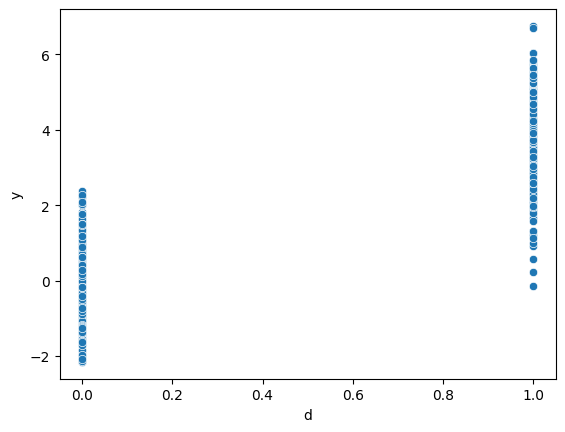

In [5]:
# Plot of the treatment and observed outcomes
sns.scatterplot(x='d', y='y', data=data)

Note that we would have a biased treatment effect because we did not consider the nuiance variables.

In [6]:
print(data.query('d == 1').y.mean() - data.query('d == 0').y.mean())

3.5375869229897594


Calculate the average treatment effect using Double ML library

In [71]:
# Test out the DoubleML using linear regression
obj_dml_data = DoubleMLData(data, 'y', 'd')

learner = LinearRegression()
ml_l = clone(learner)
ml_m = clone(learner)

obj_dml_plr_sim = DoubleMLPLR(obj_dml_data, ml_l, ml_m)
obj_dml_plr_sim.fit()
print(obj_dml_plr_sim)

================== DoubleMLPLR Object ==================

------------------ Data summary      ------------------
Outcome variable: y
Treatment variable(s): ['d']
Covariates: ['X1', 'X2', 'X3']
Instrument variable(s): None
No. Observations: 500

------------------ Score & algorithm ------------------
Score function: partialling out
DML algorithm: dml2

------------------ Machine learner   ------------------
Learner ml_l: LinearRegression()
Learner ml_m: LinearRegression()
Out-of-sample Performance:
Learner ml_l RMSE: [[1.52562481]]
Learner ml_m RMSE: [[0.39035412]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1
Apply cross-fitting: True

------------------ Fit summary       ------------------
       coef  std err          t          P>|t|     2.5 %    97.5 %
d  2.850105  0.12873  22.140149  1.298072e-108  2.597798  3.102411


Referencing Double ML from Causal Inference for the Brave and True - use OLS to get the treatment effect

In [284]:
# The denoise y and debias m models
my = smf.ols("y ~ X1 + X2 + X3", data=data).fit()
mt = smf.ols("d ~ X1 + X2 + X3", data=data).fit()

dml_ols = smf.ols("y_res~d_res", 
        data=data.assign(y_res=my.resid, # outcome residuals
                          d_res=mt.resid) # treatment residuals
       ).fit()

dml_ols.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-6.037e-16,0.046,-1.3e-14,1.000,-0.091,0.091
d_res,2.8446,0.119,23.822,0.000,2.610,3.079


Next apply machine learning models to debias T and denoise y.  We perform cross prediction to get out of fold residuals to prevent model overfitting.

In [40]:
y = "y"
d = "d"
X = ["X1", "X2", "X3"]

# Machine learning models
debias_m = LGBMRegressor(max_depth=3)
denoise_m = LGBMRegressor(max_depth=3)

# Get residuals for y and T
data_pred = data.assign(d_res =  data[d] - cross_val_predict(debias_m, data[X], data[d], cv=5),
                          y_res =  data[y] - cross_val_predict(denoise_m, data[X], data[y], cv=5))

# Predict the average treatment effect 
dml_ml = smf.ols(formula='y_res ~ d_res', data=data_pred).fit()
dml_ml.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0040,0.049,0.083,0.934,-0.091,0.099
d_res,2.8652,0.120,23.974,0.000,2.630,3.100


In [72]:
# Show results together
pd.DataFrame(
    {
        'models': ['double_ml_lib', 'double_ml_ols', 'double_ml_ml'],
        'ate': [obj_dml_plr_sim.coef[0], dml_ols.params['d_res'], dml_ml.params['d_res']]
    }
)

,models,ate
0,double_ml_lib,2.850105
1,double_ml_ols,2.844598
2,double_ml_ml,2.865165


So using an OLS model does just as good of a job as the ML models when the nuiance variables have a linear relationship with the outcome and treatment effect.

# B. Compare OLS and ML models for non linear nuiance parameters and continuous treatment

Simulate data where the outcome y has a nonlinear relationship y ~ X^2 with the nuiance variables.

In [172]:
np.random.seed(2023)

n_obs = 500
n_vars = 3
theta = 3
X = np.random.normal(size=(n_obs, n_vars))
d = np.dot(X, np.array([5, 5, 5])) + np.random.standard_normal(size=(n_obs,))
y = theta * d + np.dot(X*X, np.array([5, 5, 5])) + np.random.standard_normal(size=(n_obs,))

data_b = pd.DataFrame({
    'y': y,
    'd': d,
    'X1': X[:,0],
    'X2': X[:,1],
    'X3': X[:,2]
}
)

data_b.head()

,y,d,X1,X2,X3
0,-2.577790,-3.285771,0.711674,-0.324485,-1.001871
1,-5.038458,-4.229198,0.236251,-0.102160,-1.141293
2,112.072409,21.762485,2.654407,1.440605,0.098902
3,-11.161373,-22.650318,-3.121532,-1.076522,-0.325682
4,-26.327641,-12.531677,-1.035498,-0.426320,-1.029361


<Axes: xlabel='X3', ylabel='y'>

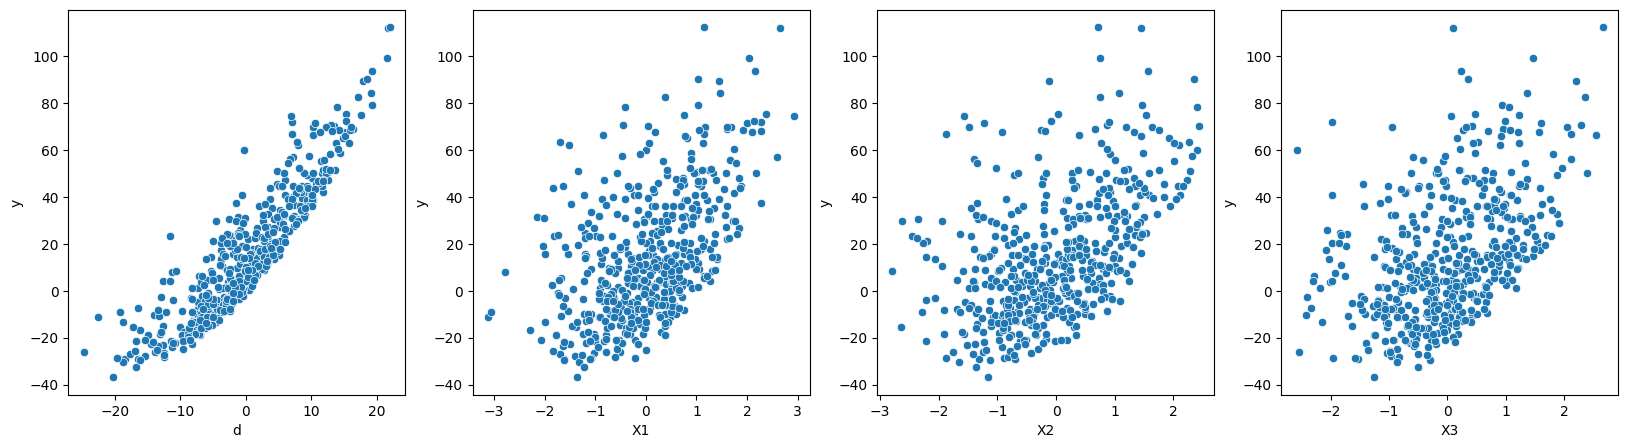

In [110]:
# Look at the data
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
sns.scatterplot(data=data_b, y='y', x='d', ax=ax[0])
sns.scatterplot(data=data_b, y='y', x='X1', ax=ax[1])
sns.scatterplot(data=data_b, y='y', x='X2', ax=ax[2])
sns.scatterplot(data=data_b, y='y', x='X3', ax=ax[3])

<Axes: xlabel='X3', ylabel='d'>

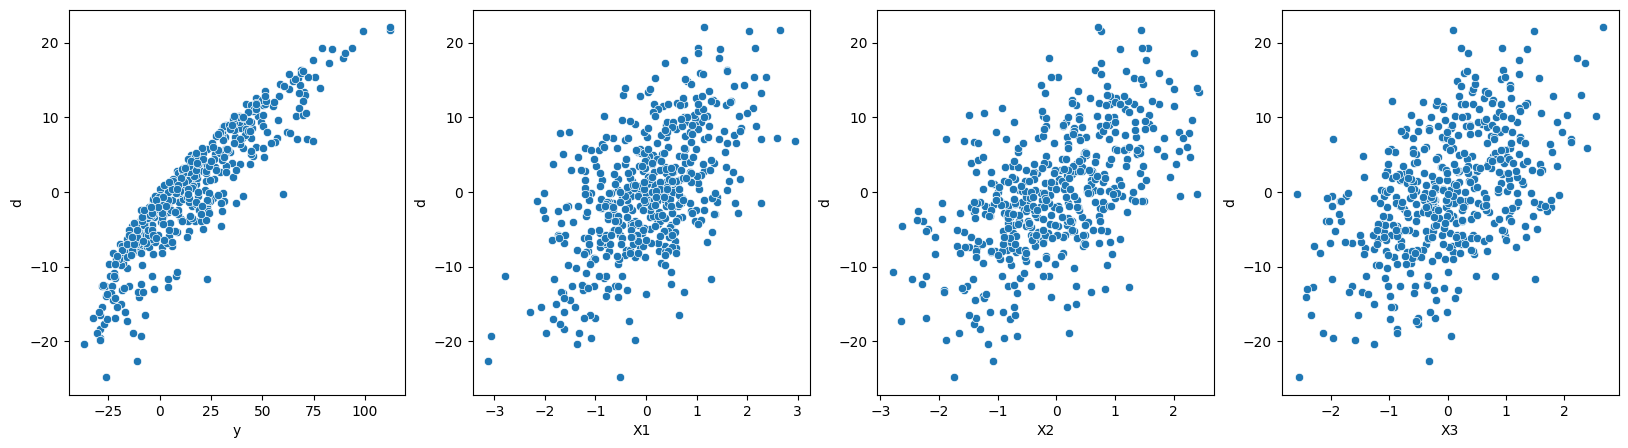

In [156]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
sns.scatterplot(data=data_b, y='d', x='y', ax=ax[0])
sns.scatterplot(data=data_b, y='d', x='X1', ax=ax[1])
sns.scatterplot(data=data_b, y='d', x='X2', ax=ax[2])
sns.scatterplot(data=data_b, y='d', x='X3', ax=ax[3])

First use a linear model for both the debias and denoise, then use a nonlinear model for the denoise

In [139]:
# Linear nuiance models for both y and d
y = "y"
d = "d"
X = ["X1", "X2", "X3"]

# Machine learning models
debias_m = LinearRegression()
denoise_m = LinearRegression()

# Get residuals for y and T
data_pred = data.assign(d_res =  data_b[d] - cross_val_predict(debias_m, data_b[X], data_b[d], cv=5),
                          y_res =  data_b[y] - cross_val_predict(denoise_m, data_b[X], data_b[y], cv=5))

# Predict the average treatment effect 
model_b_linear_linear = smf.ols(formula='y_res ~ d_res', data=data_pred).fit()
model_b_linear_linear.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0565,0.527,0.107,0.915,-0.980,1.093
d_res,3.4231,0.559,6.119,0.000,2.324,4.522


In [161]:
# Nonlinear nuiance model y
y = "y"
d = "d"
X = ["X1", "X2", "X3"]

# Machine learning models
debias_m = LinearRegression()
denoise_m = LGBMRegressor(max_depth=3) # Nonlinear 

# Get residuals for y and T
data_pred = data.assign(d_res =  data_b[d] - cross_val_predict(debias_m, data_b[X], data_b[d], cv=5),
                          y_res =  data_b[y] - cross_val_predict(denoise_m, data_b[X], data_b[y], cv=5))

# Predict the average treatment effect 
model_b_linear_nonlinear = smf.ols(formula='y_res ~ d_res', data=data_pred).fit()
model_b_linear_nonlinear.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0200,0.287,0.070,0.944,-0.543,0.583
d_res,2.9236,0.304,9.617,0.000,2.326,3.521


In [168]:
# Both nonlinear models for both y and d
y = "y"
d = "d"
X = ["X1", "X2", "X3"]

# Machine learning models
debias_m = LGBMRegressor(max_depth=3)
denoise_m = LGBMRegressor(max_depth=3)

# Get residuals for y and T
data_pred = data.assign(d_res =  data_b[d] - cross_val_predict(debias_m, data_b[X], data_b[d], cv=5),
                          y_res =  data_b[y] - cross_val_predict(denoise_m, data_b[X], data_b[y], cv=5))

# Predict the average treatment effect 
model_b_nonlinear_nonlinear = smf.ols(formula='y_res ~ d_res', data=data_pred).fit()
model_b_nonlinear_nonlinear.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0279,0.254,0.110,0.913,-0.471,0.527
d_res,2.1890,0.137,15.940,0.000,1.919,2.459


In [163]:
# Show results together
pd.DataFrame(
    {
        'models': ['model_b_linear_linear', 'model_b_linear_nonlinear', 'model_b_nonlinear_nonlinear'],
        'ate': [model_b_linear_linear.params['d_res'], model_b_linear_nonlinear.params['d_res'], model_b_nonlinear_nonlinear.params['d_res']]
    }
)


,models,ate
0,model_b_linear_linear,3.423058
1,model_b_linear_nonlinear,2.923628
2,model_b_nonlinear_nonlinear,2.188993


We can see that the linear nuiance models overestimate the treatment effect.  Including nonlinear model for the y ~ x but a linear model for d ~ x produces one a treatment effect close to the true treatment effect.  

While using a nonlinear model for debias and denoise resulted in underestimating the treatment effect.  This makes sense in that it we need different hyperparameters for the tree model to linear a linear effect.

In [169]:
# For example if we used a linear tree instead 
# Both nonlinear models for both y and d
y = "y"
d = "d"
X = ["X1", "X2", "X3"]

# Machine learning models
debias_m = LGBMRegressor(max_depth=3, linear_tree=True)
denoise_m = LGBMRegressor(max_depth=3)

# Get residuals for y and T
data_pred = data.assign(d_res =  data_b[d] - cross_val_predict(debias_m, data_b[X], data_b[d], cv=5),
                          y_res =  data_b[y] - cross_val_predict(denoise_m, data_b[X], data_b[y], cv=5))

# Predict the average treatment effect 
model_b_nonlinear_nonlinear = smf.ols(formula='y_res ~ d_res', data=data_pred).fit()
model_b_nonlinear_nonlinear.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.0078,0.279,-0.028,0.978,-0.557,0.541
d_res,2.8479,0.256,11.118,0.000,2.345,3.351


This suggest we still need to fit the right ML nuiance models.

# C. Compare OLS and ML models for non linear treatment effect

Here we simulate data were y ~ sqrt(d), thus a treatment effect of $\theta = 0.5/sqrt(d)$.  The nuiance variables X has a linear relationship with y and d.

In [194]:
np.abs(np.dot(X, np.array([5, 5, 5])))

array([ 3.07341032,  5.03600836, 20.96957362, ...,  2.41479211,
        4.18677258, 16.699629  ])

In [215]:
np.random.seed(2023)

n_obs = 5000
n_vars = 3
# theta = 3
X = np.random.normal(size=(n_obs, n_vars))
d = np.abs(np.dot(X, np.array([5, 5, 5]))) + np.random.gamma(2, 10, size=(n_obs,))
y = 10*np.sqrt(d) + np.dot(X, np.array([5, 5, 5])) + np.random.standard_normal(size=(n_obs,))

data_c = pd.DataFrame({
    'y': y,
    'd': d,
    'X1': X[:,0],
    'X2': X[:,1],
    'X3': X[:,2]
}
)

data_c.head()

,y,d,X1,X2,X3
0,54.149097,32.067589,0.711674,-0.324485,-1.001871
1,39.154568,19.223295,0.236251,-0.102160,-1.141293
2,83.816829,38.154464,2.654407,1.440605,0.098902
3,39.686859,36.625873,-3.121532,-1.076522,-0.325682
4,46.396714,34.767122,-1.035498,-0.426320,-1.029361


<Axes: xlabel='X3', ylabel='y'>

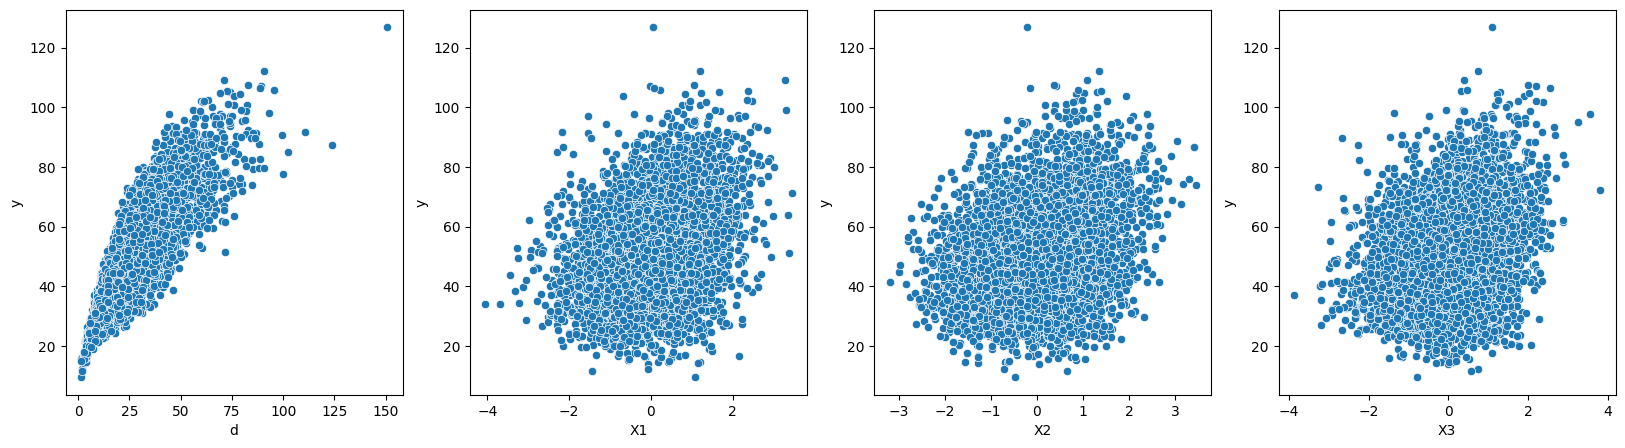

In [216]:
# Look at the data
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
sns.scatterplot(data=data_c, y='y', x='d', ax=ax[0])
sns.scatterplot(data=data_c, y='y', x='X1', ax=ax[1])
sns.scatterplot(data=data_c, y='y', x='X2', ax=ax[2])
sns.scatterplot(data=data_c, y='y', x='X3', ax=ax[3])

In [217]:
# Linear model to treatment effect - from brave and true
y = "y"
d = "d"
X = ["X1", "X2", "X3"]

# Machine learning models
debias_m = LinearRegression()
denoise_m = LinearRegression()

# Get residuals for y and T
d_res =  data_c[d] - cross_val_predict(debias_m, data_c[X], data_c[d], cv=5)
y_res =  data_c[y] - cross_val_predict(denoise_m, data_c[X], data_c[y], cv=5)

# linear causal model
linear_param = LinearRegression()
w = d_res ** 2 
y_star = y_res / d_res

linear_param.fit(X=d_res.ravel().reshape(-1,1), y=y_star.ravel(), sample_weight=w.ravel())

LinearRegression()

In [218]:
# Non linear model to treatment effect
y = "y"
d = "d"
X = ["X1", "X2", "X3"]

# Machine learning models
debias_m = LinearRegression()
denoise_m = LinearRegression()

# Get residuals for y and T
d_res =  data_c[d] - cross_val_predict(debias_m, data_c[X], data_c[d], cv=5)
y_res =  data_c[y] - cross_val_predict(denoise_m, data_c[X], data_c[y], cv=5)

non_param = LGBMRegressor(max_depth=3)
w = d_res ** 2 
y_star = y_res / d_res

non_param.fit(X=d_res.ravel().reshape(-1,1), y=y_star.ravel(), sample_weight=w.ravel())

LGBMRegressor(max_depth=3)

/Users/S/Desktop/projects/causal_inference/.venv/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


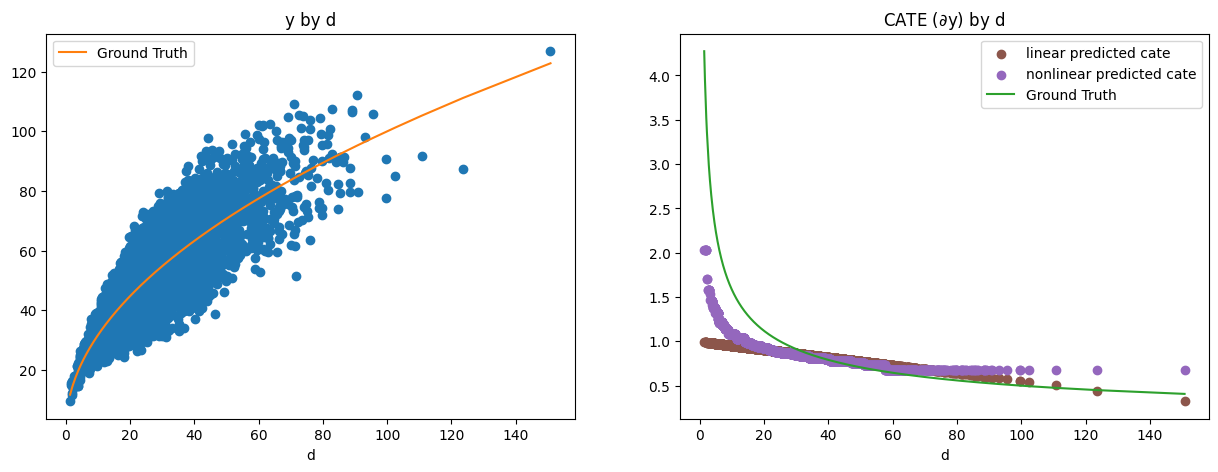

In [235]:
linear_cate = linear_param.predict(X=data_c[['d']])
nonlinear_cate = non_param.predict(X=data_c[['d']])

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(data_c['d'], data_c['y'])
plt.plot(data_c['d'].sort_values(), 10*np.sqrt(data_c['d'].sort_values()), label="Ground Truth", c="C1")
plt.title("y by d")
plt.xlabel("d")
plt.legend()

plt.subplot(1,2,2)
plt.scatter(data_c['d'], linear_cate, label="linear predicted cate", c="C5")
plt.scatter(data_c['d'], nonlinear_cate, label="nonlinear predicted cate", c="C4")
plt.plot(data_c['d'].sort_values(), 5/np.sqrt(data_c['d'].sort_values()), label="Ground Truth", c="C2")
plt.title("CATE ($\partial$y) by d")
plt.xlabel("d")
plt.legend()

In [236]:
print(linear_cate.mean())
print(nonlinear_cate.mean())

0.875399977164475
0.9064620959047778


# End